In [1]:
import pandas as pd
import pdb
from pathlib import Path
from fastai.vision import *
from fastai.vision.gan import *
from sklearn.decomposition import PCA
from pathlib import Path
path = Path("UCRArchive_2018/InsectWingbeatSound")

In [6]:
list(path.iterdir())

[WindowsPath('UCRArchive_2018/InsectWingbeatSound/desktop.ini'),
 WindowsPath('UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TEST.tsv'),
 WindowsPath('UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TRAIN.tsv'),
 WindowsPath('UCRArchive_2018/InsectWingbeatSound/README.md')]

In [253]:
trainDF = pd.read_csv(path/"InsectWingbeatSound_TRAIN.tsv",sep="\t",header=None)
valDF = pd.read_csv(path/"InsectWingbeatSound_TEST.tsv",sep="\t",header=None)
print(trainDF.shape,valDF.shape)

(220, 257) (1980, 257)


In [8]:
trainDS = torch.utils.data.TensorDataset(torch.tensor(trainDF.iloc[:,1:].values,dtype=torch.float),torch.tensor(trainDF.iloc[:,0].values,dtype=torch.long))
valDS = torch.utils.data.TensorDataset(torch.tensor(valDF.iloc[:,1:].values,dtype=torch.float),torch.tensor(valDF.iloc[:,0].values,dtype=torch.long))
trainDS.items, valDS.items = [1,2,3],[1,2,3]
numClasses = len(trainDF.iloc[:,0].unique())
seqLen = trainDF.shape[1]-1
dataClassifier = DataBunch.create(trainDS,valDS,num_workers=0)

In [9]:
tT = torch.tensor(trainDF.iloc[:,1:].values,dtype=torch.float)
vT = torch.tensor(valDF.iloc[:,1:].values,dtype=torch.float)
combT = torch.cat([tT,vT])
trainDS = torch.utils.data.TensorDataset(combT,combT)
valDS = torch.utils.data.TensorDataset(vT,vT)
trainDS.items, valDS.items = [1,2,3],[1,2,3]
dataAE = DataBunch.create(trainDS,valDS,num_workers=0)

In [292]:
def convBlock(nIn,nOut,ks,stride):
    return torch.nn.Sequential(torch.nn.Conv1d(nIn,nOut,ks,stride),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm1d(nOut))

def deconvBlock(nIn,nOut,ks,stride):
    return torch.nn.Sequential(torch.nn.ConvTranspose1d(nIn,nOut,ks,stride),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm1d(nOut))

In [312]:
class TSAE(torch.nn.Module):
    def __init__(self,seqLen):
        super().__init__()
        self.conv1 = convBlock(1,10,4,2)
        self.conv2 = convBlock(10,20,3,2)
        self.conv3 = convBlock(20,40,3,2)
        self.deconv1 = deconvBlock(40,20,3,2)
        self.deconv2 = deconvBlock(20,10,3,2)
        self.deconv3 = deconvBlock(10,1,4,2)
        
    def forward(self,ts):
        ts = self.conv3(self.conv2(self.conv1(ts.unsqueeze(1))))
        ts = self.deconv3(self.deconv2(self.deconv1(ts)))
        return ts.squeeze(1)

In [286]:
class TSClassifier(torch.nn.Module):
    def __init__(self,seqLen,numClasses):
        super().__init__()
        self.conv1 = convBlock(1,10,4,2)
        self.conv2 = convBlock(10,20,3,2)
        self.conv3 = convBlock(20,1,4,2)
        self.conv4 = convBlock(40,80,4,2)
        self.conv5 = convBlock(80,160,4,2)
        self.pool = torch.nn.AdaptiveAvgPool1d(1)
        self.out = torch.nn.Linear(30,numClasses)
        
    def forward(self,ts):
        ts = self.conv3(self.conv2(self.conv1(ts.unsqueeze(1))))
        #ts = self.conv5(self.conv4(ts))
        #ts = self.pool(ts)
        return self.out(ts.squeeze(1))

In [313]:
learnAE = Learner(dataAE,TSAE(seqLen),loss_func=torch.nn.functional.mse_loss)

In [314]:
x,y = next(iter(dataAE.train_dl))
learnAE.model(x).size()

torch.Size([64, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


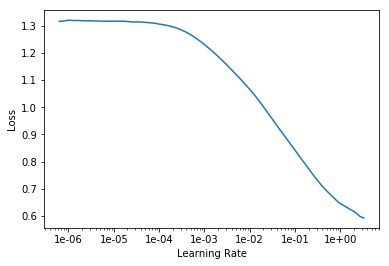

In [315]:
learnAE.lr_find()
learnAE.recorder.plot()

In [316]:
learnAE.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss
1,0.838970,0.794093
2,0.563090,0.270015
3,0.320782,0.039393
4,0.169608,0.019900
5,0.089342,0.016493
6,0.048583,0.013378
7,0.027502,0.011278
8,0.016366,0.008205
9,0.010840,0.011817
10,0.007499,0.005463


In [325]:
learnClassifier = Learner(dataClassifier,TSClassifier(seqLen,numClasses),loss_func=torch.nn.functional.cross_entropy,metrics=[accuracy])
learnClassifier.split(split_model_idx(learnClassifier.model,idxs=[0,6]))

In [326]:
learnClassifier.model.conv1.load_state_dict(learnAE.model.conv1.state_dict())
learnClassifier.model.conv2.load_state_dict(learnAE.model.conv2.state_dict())

In [304]:
x,y = next(iter(dataClassifier.train_dl))
learnClassifier.model(x).size()

torch.Size([64, 11])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


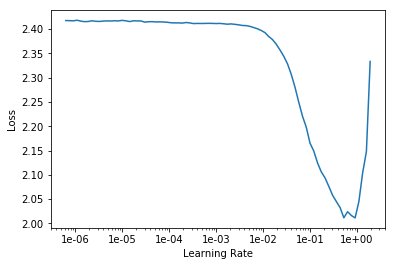

In [306]:
learnClassifier.lr_find()
learnClassifier.recorder.plot()

In [327]:
learnClassifier.freeze_to(1)

In [328]:
learnClassifier.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss,accuracy
1,2.537117,2.442442,0.106566
2,2.516059,2.429706,0.112121
3,2.488025,2.403036,0.105051
4,2.455284,2.383212,0.106061
5,2.430596,2.332999,0.176263
6,2.395768,2.184947,0.244444
7,2.347283,1.988150,0.281818
8,2.288936,1.812615,0.339899
9,2.222070,1.674804,0.400000
10,2.152558,1.566910,0.434848


In [329]:
learnClassifier.unfreeze()

In [330]:
learnClassifier.fit_one_cycle(20,[1e-3,1e-2])

epoch,train_loss,valid_loss,accuracy
1,1.225519,1.363972,0.504545
2,1.234488,1.358694,0.511111
3,1.245688,1.341753,0.515152
4,1.242350,1.318341,0.522727
5,1.233701,1.296754,0.523232
6,1.219500,1.277259,0.532323
7,1.211358,1.272899,0.539899
8,1.193687,1.262087,0.532323
9,1.169926,1.250672,0.540404
10,1.153720,1.251991,0.541919


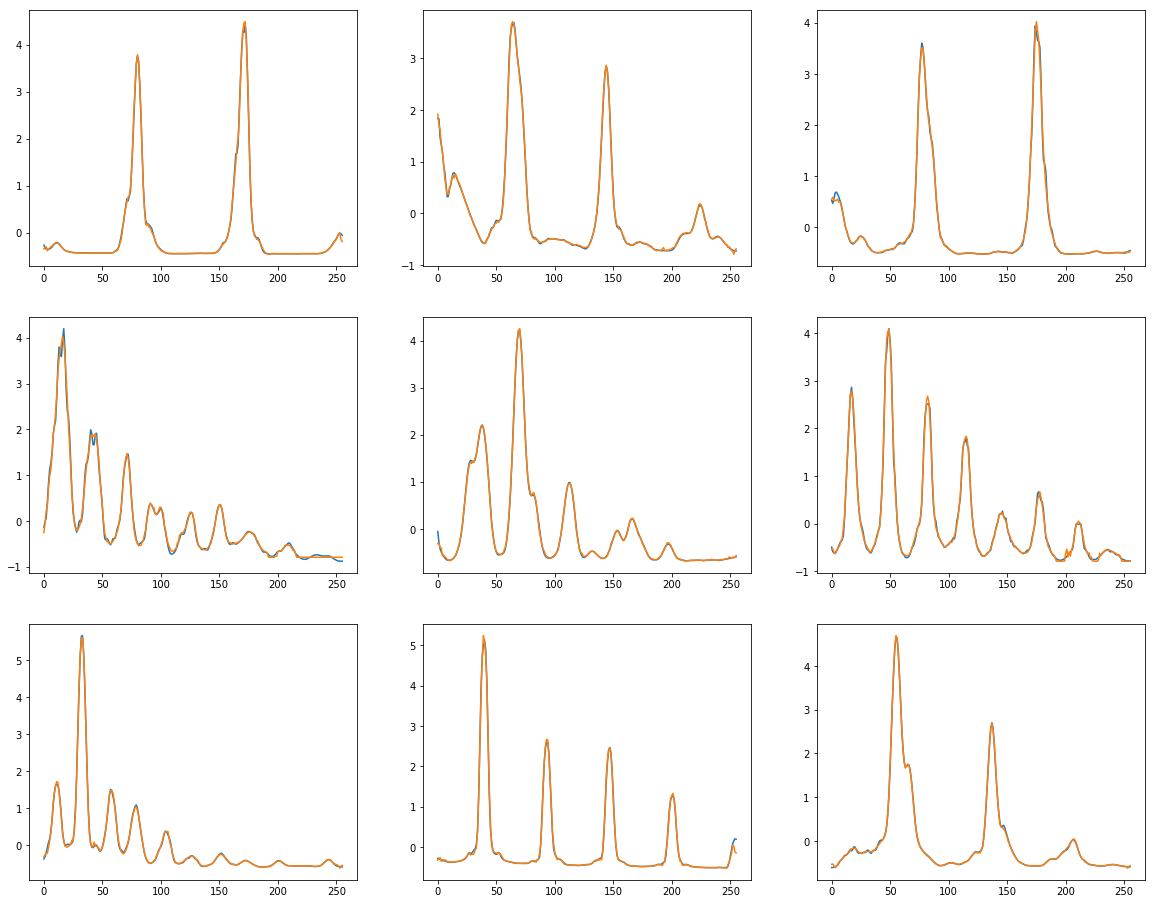

In [317]:
x,y = next(iter(dataAE.train_dl))
learnAE.model.eval()
preds = learnAE.model(x)
_,axes = plt.subplots(3,3,figsize=(20,16))
for ax, ts, p, in zip(axes.flatten(),x,preds):
    ax.plot(ts)
    ax.plot(p)
    